# PINN for solving Burger's equation 

$$
\frac{\partial u}{\partial t} + u \frac{\partial  u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

N-Wave type solution with starting waveform being 

$$
u(x,0) = \mathrm{e}^{(x-1)^2/2} - \mathrm{e}^{(x+1)^2/2}
$$
with $\nu = 0.01$.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()

In [3]:
class PINN(nn.Module):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            num_outputs: int=1,
            activation: nn.Module = nn.Tanh()
    ):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.num_outputs = num_outputs
        self.activation = activation

        layers = [nn.Linear(num_inputs, num_neurons)]

        for _ in range(num_hidden_layers):
            layers.append(activation)
            layers.append(nn.Linear(num_neurons, num_neurons))
        
        layers.append(activation)
        layers.append(nn.Linear(num_neurons, num_outputs))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [38]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 50000 #how many times the training step is performed
BATCH_SIZE = 100 # how many input values are considered for each epoch
LEARNING_RATE = 1e-3
TOLERANCE = 2e-5
NUM_INPUTS = 2

v = 0.01

T_DOMAIN = (0.0, 5.0)
X_DOMAIN = (-6.0, 6.0)
T_BOUNDARY = torch.cat([torch.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE).unsqueeze(1), torch.full((BATCH_SIZE, 1), T_DOMAIN[0])], dim=1)
X_BOUNDARY_0 = torch.cat([torch.full((BATCH_SIZE, 1), X_DOMAIN[0]), torch.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE).unsqueeze(1)], dim=1)
X_BOUNDARY_1 = torch.cat([torch.full((BATCH_SIZE, 1), X_DOMAIN[1]), torch.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE).unsqueeze(1)], dim=1)


def loss_function(
        model: nn.Module, 
        xt: torch.Tensor
        ) -> torch.Tensor:
    x = xt[:, 0].unsqueeze(1)
    t = xt[:, 1].unsqueeze(1)
    
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(torch.cat([x, t], dim=1))

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    de = u_t + u * u_x - v * u_xx

    t_boundary_xvals = T_BOUNDARY[:, 0].unsqueeze(1)
    boundary_x_0 = model(T_BOUNDARY) - torch.exp(-torch.square(t_boundary_xvals - torch.ones_like(t_boundary_xvals)) / 2.0) + torch.exp(-torch.square(t_boundary_xvals + torch.ones_like(t_boundary_xvals)) / 2.0)

    loss_val = torch.mean(de ** 2) + torch.mean(boundary_x_0 ** 2)

    return loss_val

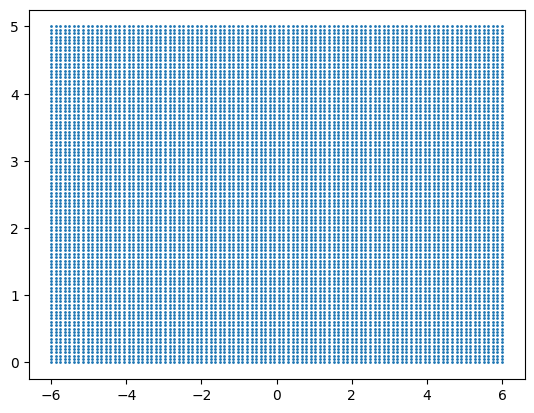

In [8]:
x_plot = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE).unsqueeze(1)
t_plot = torch.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE).unsqueeze(1)
X_mesh, T_mesh = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing='ij')
X_pred = X_mesh.reshape(-1, 1)
T_pred = T_mesh.reshape(-1, 1)

plt.scatter(X_pred, T_pred, s=1)
plt.show()

In [40]:
from IPython.display import clear_output

INPUT = torch.cat([X_pred, T_pred], dim=1)
INPUT.requires_grad_(True)
model = PINN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_step(model,input):
    optimizer.zero_grad()
    loss = loss_function(model, input)
    loss.backward()
    optimizer.step()

    return loss

for epoch in range(EPOCHS): 
    loss = train_step(model, INPUT) 
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')
    if loss <= TOLERANCE:
        break

clear_output()



Epoch: 2700, Loss: 0.0016914521111175418


In [34]:
fun = model(INPUT)

MovieWriter Pillow unavailable; using Pillow instead.


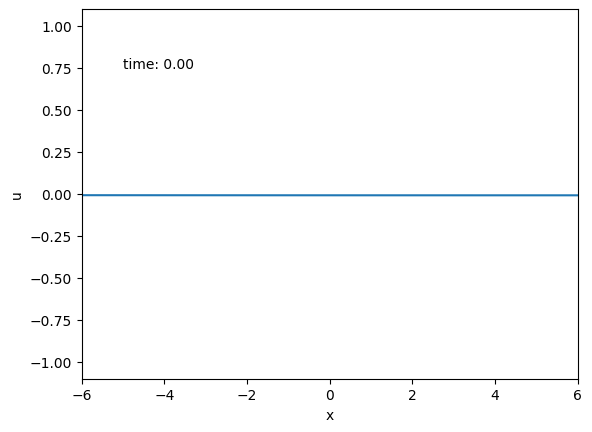

In [35]:
fig, ax = plt.subplots()
ax.grid(True)

def animate(i):
    time = str(i*(T_DOMAIN[1] - T_DOMAIN[0])/BATCH_SIZE)
    plt.cla()
    plt.text(-5.0, 0.75, f"time: {time.ljust(4, '0')}")
    plt.plot(x_plot.detach(), fun[i*BATCH_SIZE : (i+1)*BATCH_SIZE].detach())
    plt.xlim(X_DOMAIN[0], X_DOMAIN[1])  
    plt.ylim(-1.1,1.1)
    plt.xlabel("x")
    plt.ylabel("u")

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=BATCH_SIZE)
ani.save('burgers.gif', writer='Pillow', fps=5)


In [27]:
from matplotlib.colors import LinearSegmentedColormap

color_min    = "#0000FF"
color_min2   = "#00008B"
color_center = "#000000" # black
color_max2   = "#ffA500"
color_max    = "#ffff00"
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_min2, color_center, color_max2, color_max]
)

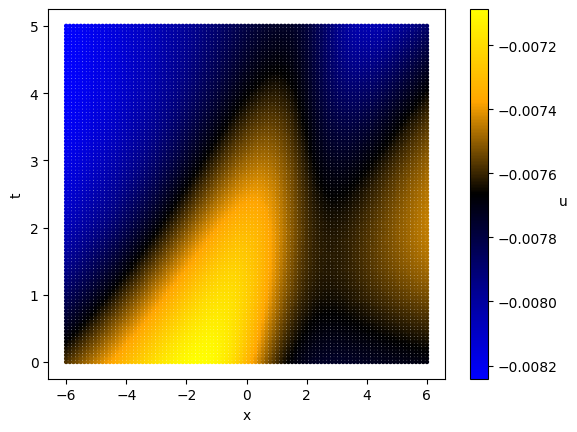

In [36]:
plt.scatter(X_pred.detach(), T_pred.detach(), c=fun.detach(), s=5, cmap=cmap)
plt.xlabel('x')
plt.ylabel('t')
cbar = plt.colorbar()
cbar.set_label('u', rotation=0)
plt.show()